In [3]:
!pip install mediapipe opencv-python tensorflow scikit-learn matplotlib albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 49.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 36.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 25.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.8 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible

In [2]:
import os
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np



2025-11-15 09:22:40.141111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763198560.361320      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763198560.432453      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
BASE_DIR = "/kaggle/input/yoga-poses-dataset/DATASET"

TRAIN_DIR = os.path.join(BASE_DIR, "TRAIN")
TEST_DIR  = os.path.join(BASE_DIR, "TEST")

In [16]:
OUT_TRAIN_KP = "/kaggle/working/yoga_small_train_kp"
OUT_TEST_KP  = "/kaggle/working/yoga_small_test_kp"

os.makedirs(OUT_TRAIN_KP, exist_ok=True)
os.makedirs(OUT_TEST_KP, exist_ok=True)


In [4]:
def count_images(folder):
    counts = {}
    for cls in sorted(os.listdir(folder)):
        path = os.path.join(folder, cls)
        if os.path.isdir(path):
            counts[cls] = len(os.listdir(path))
    return counts

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

print("TRAIN:", train_counts)
print("TEST:", test_counts)


TRAIN: {'downdog': 223, 'goddess': 180, 'plank': 266, 'tree': 160, 'warrior2': 252}
TEST: {'downdog': 97, 'goddess': 80, 'plank': 115, 'tree': 69, 'warrior2': 109}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


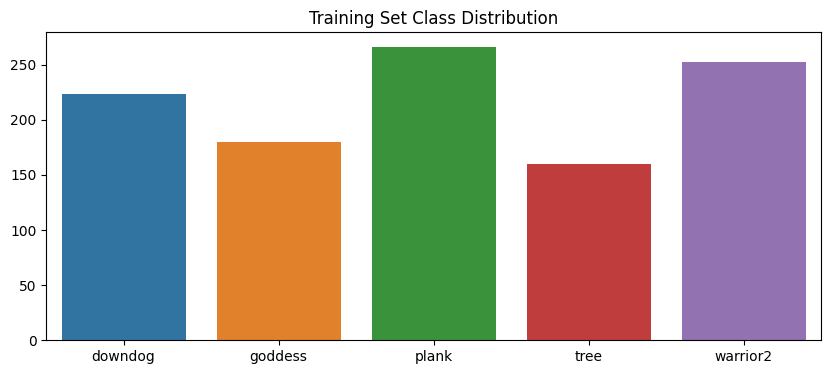

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


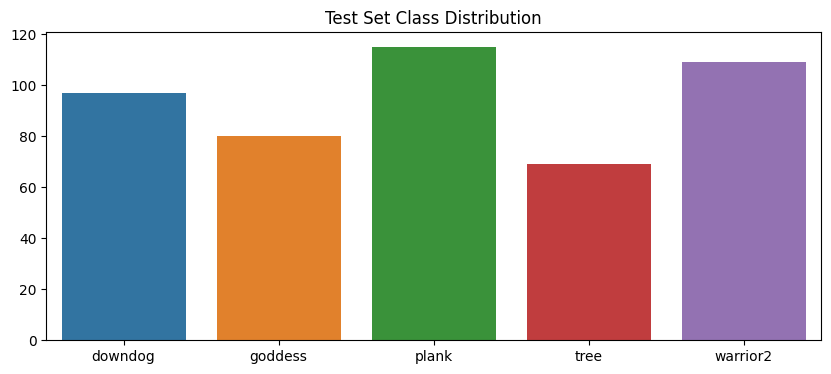

In [5]:
plt.figure(figsize=(10,4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Training Set Class Distribution")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title("Test Set Class Distribution")
plt.show()


W0000 00:00:1763198870.300646     142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763198870.356555     142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763198870.381675     142 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


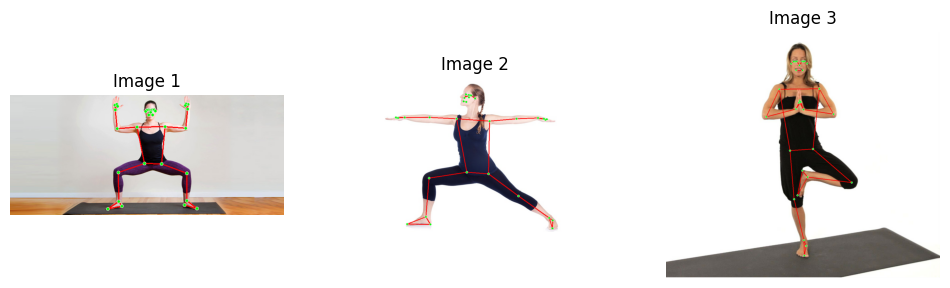

In [7]:
mp_pose = mp.solutions.pose
POSE = mp_pose.Pose(static_image_mode=True, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils



# ✅ Visualize 2–3 images with keypoints
def visualize_keypoints(image_paths):
    plt.figure(figsize=(12, 6))
    
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = POSE.process(img_rgb)
        
        # Draw skeleton
        drawn = img_rgb.copy()
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                drawn,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2),
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(255,0,0), thickness=2)
            )
        
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(drawn)
        plt.title(f"Image {i+1}")
        plt.axis("off")

    plt.show()


# ▶️ Example usage
sample_images = [
    "/kaggle/input/yoga-poses-dataset/DATASET/TEST/goddess/00000001.jpg",
    "/kaggle/input/yoga-poses-dataset/DATASET/TEST/warrior2/00000003.jpg",
    "/kaggle/input/yoga-poses-dataset/DATASET/TEST/tree/00000008.jpg"
]

visualize_keypoints(sample_images)


In [17]:

# Keypoint extraction
mp_pose = mp.solutions.pose
POSE = mp_pose.Pose(static_image_mode=True, min_tracking_confidence=0.5)

def extract_landmarks(image):
    results = POSE.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not results.pose_landmarks:
        return None
    
    lm = []
    for l in results.pose_landmarks.landmark:
        lm.append([l.x, l.y, l.z])  # (x, y, z)
    
    return np.array(lm)  # shape (33, 3)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1763191297.681744     133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763191297.739700     133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [18]:
# Image to .npy file
def process_split(INPUT_DIR, OUTPUT_DIR):
    classes = [d for d in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, d))]

    for cls in classes:
        cls_path = os.path.join(INPUT_DIR, cls)
        out_class = os.path.join(OUTPUT_DIR, cls)
        os.makedirs(out_class, exist_ok=True)

        img_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]

        for imgf in tqdm(img_files, desc=f"Extracting: {cls}"):
            img_path = os.path.join(cls_path, imgf)
            img = cv2.imread(img_path)
            if img is None: continue

            keypoints = extract_landmarks(img)
            if keypoints is None:
                continue

            np.save(os.path.join(out_class, imgf.replace(".jpg", ".npy").replace(".png",".npy")), keypoints)


In [19]:
process_split(TRAIN_DIR, OUT_TRAIN_KP)
process_split(TEST_DIR, OUT_TEST_KP)


Extracting: goddess: 100%|██████████| 80/80 [00:04<00:00, 17.41it/s]


In [20]:
# Sequence building of 45 frames
def build_sequences(KEYPOINT_DIR, out_npz):
    classes = sorted(os.listdir(KEYPOINT_DIR))
    X = []
    y = []

    cls2idx = {c:i for i,c in enumerate(classes)}

    for cls in classes:
        cls_path = os.path.join(KEYPOINT_DIR, cls)
        files = [f for f in os.listdir(cls_path) if f.endswith('.npy')]

        for f in files:
            kp = np.load(os.path.join(cls_path, f))  # (33,3)

            # Repeat a single keypoint frame 45 times
            seq = np.repeat(kp[np.newaxis, :, :], 45, axis=0)  # (45,33,3)

            X.append(seq)
            y.append(cls2idx[cls])

    X = np.array(X)
    y = np.array(y)

    X = X.reshape(X.shape[0], 45, 99).astype("float32")

    np.savez_compressed(out_npz, X=X, y=y, classes=np.array(classes))
    print("Saved:", out_npz)


In [21]:
build_sequences(OUT_TRAIN_KP, "/kaggle/working/train_sequences_small.npz")
build_sequences(OUT_TEST_KP,  "/kaggle/working/test_sequences_small.npz")


Saved: /kaggle/working/train_sequences_small.npz
Saved: /kaggle/working/test_sequences_small.npz


In [4]:

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
# train_yoga_model.py

train_data = np.load("/kaggle/working/train_sequences_small.npz", allow_pickle=True)
X_train, y_train, classes = train_data["X"], train_data["y"], train_data["classes"]

test_data = np.load("/kaggle/working/test_sequences_small.npz", allow_pickle=True)
X_test, y_test = test_data["X"], test_data["y"]

num_classes = len(classes)

model = models.Sequential([
    layers.Input(shape=(45, 99)),
    layers.TimeDistributed(layers.Dense(128, activation='relu')),
    layers.LSTM(128),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=8)


I0000 00:00:1763191483.646199      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763191483.647100      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/30


I0000 00:00:1763191487.860118     155 cuda_dnn.cc:529] Loaded cuDNN version 90300


131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4712 - loss: 1.1757
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6959 - loss: 0.7216
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8070 - loss: 0.5076
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8265 - loss: 0.4926
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8513 - loss: 0.4337
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8823 - loss: 0.3651
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8851 - loss: 0.3579
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8657 - loss: 0.3922
Epoch 9/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8897 - loss: 0.3147
Epoch 10/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9096 - loss: 0.2592
Epoch 11/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9232 - loss: 0.2403
Epoch 12/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

In [25]:
pred = model.predict(X_test)
pred_labels = pred.argmax(axis=1)

print(classification_report(y_test, pred_labels, target_names=classes))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
              precision    recall  f1-score   support

     downdog       0.99      1.00      0.99        94
     goddess       0.95      0.91      0.93        80
       plank       0.98      0.98      0.98       115
        tree       0.96      0.99      0.97        69
    warrior2       0.96      0.96      0.96       107

    accuracy                           0.97       465
   macro avg       0.97      0.97      0.97       465
weighted avg       0.97      0.97      0.97       465



In [26]:
model.save("/kaggle/working/yoga_small_model.h5")
print("Model saved as yoga_small_model.h5")


Model saved as yoga_small_model.h5


In [6]:
model = models.Sequential([
    layers.Input(shape=(45, 99)),
    layers.TimeDistributed(layers.Dense(128, activation='relu')),
    layers.LSTM(128),
    layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 45, 128)        │        12,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,158 (567.02 KB)

 Trainable params: 145,158 (567.02 KB)

 Non-trainable params: 0 (0.00 B)